# 🏆 AI Talents League R1: A Deep Dive into Sales Prediction


## 📖 Introduction: The Quest for Accurate Predictions

Welcome to my detailed exploration of the AI Talents League Round 1 competition! The challenge is to predict product sales (`Y`) based on a variety of product and outlet features. In this notebook, I will walk you through a complete machine learning workflow, from initial data exploration and cleaning to advanced feature engineering and final model submission.

My approach is built on the philosophy of **"understanding before predicting."** I believe that a thorough analysis of the data's structure, distributions, and hidden relationships is the key to building a robust and high-performing model.

### 🎯 Our Workflow at a Glance:
1.  **Initial Setup**: Importing libraries and loading the dataset.
2.  **Exploratory Data Analysis (EDA)**: Uncovering insights, visualizing distributions, and understanding feature relationships. We'll look at the target variable, numerical features, and categorical features.
3.  **Data Cleaning & Preprocessing**: Systematically handling missing values, duplicates, and outliers to create a clean foundation for our model.
4.  **Advanced Feature Engineering**: Creating new, powerful features from the existing data to boost model performance.
5.  **Modeling & Prediction**: Building a powerful `RandomForestRegressor` model, transforming the features, and generating the final predictions for submission.

Let's begin this journey and transform raw data into actionable predictions! 🚀

---

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import shap
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, PolynomialFeatures, OneHotEncoder, RobustScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

# Loading El Data

In [ ]:
# Load el Data
train_df = pd.read_csv('/kaggle/input/ai-talents-league-round-1/train.csv')
test_df = pd.read_csv('/kaggle/input/ai-talents-league-round-1/test.csv')
sample_submission = pd.read_csv('/kaggle/input/ai-talents-league-round-1/sample_submission.csv')

# EDA for the train Data

In [ ]:
train_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Y
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,8.23
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,6.09
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,7.65
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,6.60
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,6.90


In [ ]:
train_df.select_dtypes(include=['object'])

,X1,X3,X5,X7,X9,X10,X11
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,NaN,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...
5995,FDB32,Low Fat,Fruits and Vegetables,OUT017,NaN,Tier 2,Supermarket Type1
5996,FDJ16,Low Fat,Frozen Foods,OUT049,Medium,Tier 1,Supermarket Type1
5997,FDJ32,Low Fat,Fruits and Vegetables,OUT045,NaN,Tier 2,Supermarket Type1
5998,FDO12,Low Fat,Baking Goods,OUT035,Small,Tier 2,Supermarket Type1


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


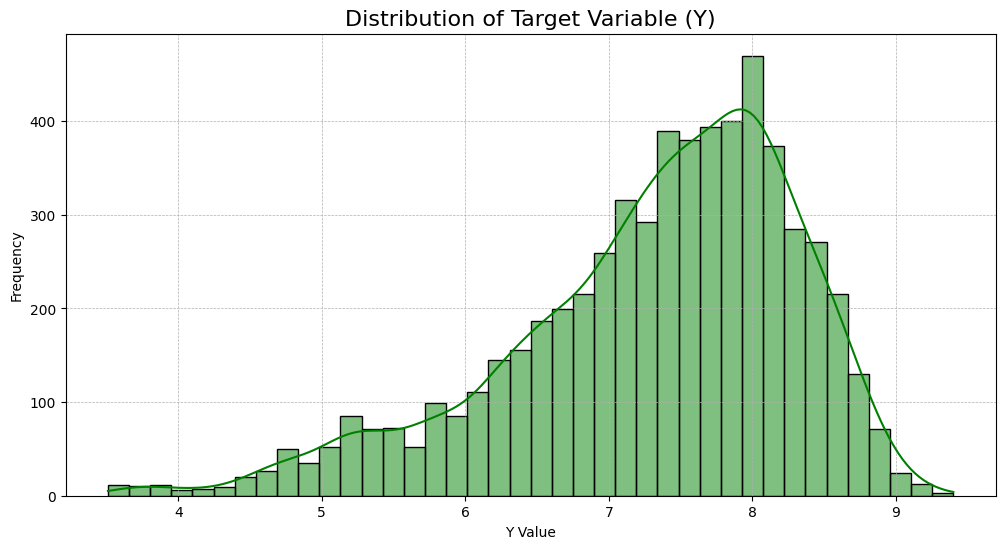

In [ ]:
# A quick look at the target 'Y' can reveal skewness or outliers.
plt.figure(figsize=(12, 6))
sns.histplot(train_df['Y'], kde=True, bins=40, color='green')
plt.title('Distribution of Target Variable (Y)', fontsize=16)
plt.xlabel('Y Value')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Wrangling, Analysis and Feature Engineering

In [ ]:
# Remove el Duplicates
initial_rows = len(train_df)
train_df.drop_duplicates(inplace=True)
print(f"Removed {initial_rows - len(train_df)} duplicate rows.")

Removed 0 duplicate rows.


In [ ]:
# Handle Outliers using IQR (Only for Numeric Columns)
# Removing extreme values that could skew the model's training.

# Define column lists early
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
if 'Y' in numeric_cols:
    numeric_cols.remove('Y') # Exclude target from operations
categorical_cols = ['X1', 'X3', 'X5', 'X7', 'X9', 'X10', 'X11']

In [ ]:
for col in categorical_cols:
  train_df[col] = train_df[col].fillna(train_df[col].mode()[0])
  test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

In [ ]:
# Missing Value Imputation (MUST be done before outlier detection)
# Filling missing values with the median, which is robust to outliers.
# We assign the result back to the column to avoid the SettingWithCopyWarning.
for col in numeric_cols:
    median_val = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_val)
    test_df[col] = test_df[col].fillna(median_val)
print("Missing values imputed using the median.")

Missing values imputed using the median.


In [ ]:
train_df['X0'] = train_df['X1'].str[:2]
test_df['X0'] = test_df['X1'].str[:2]

In [ ]:
train_df.X0.unique(), test_df.X0.unique()

(array(['FD', 'DR', 'NC'], dtype=object),
 array(['FD', 'DR', 'NC'], dtype=object))

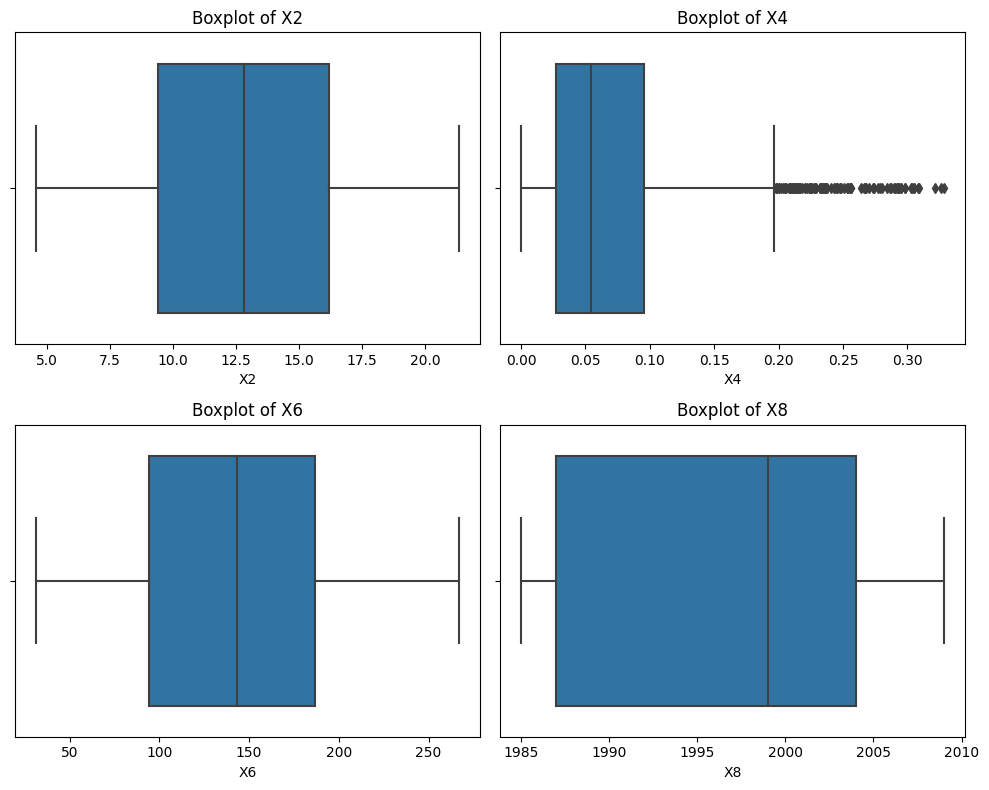

In [ ]:
# Now that data is clean, a boxplot helps visualize the outliers we're about to handle.
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, col in zip(axes.flatten(), numeric_cols):
    sns.boxplot(x=train_df[col], ax=ax, orient='h')
    ax.set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [ ]:
# Outliers Removal
Q1 = train_df[numeric_cols].quantile(0.25)
Q3 = train_df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = ~((train_df[numeric_cols] < (Q1 - 1.5 * IQR)) | (train_df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
initial_rows = len(train_df)
train_df = train_df[outlier_condition]
print(f"Removed {initial_rows - len(train_df)} rows containing outliers.")

Removed 97 rows containing outliers.


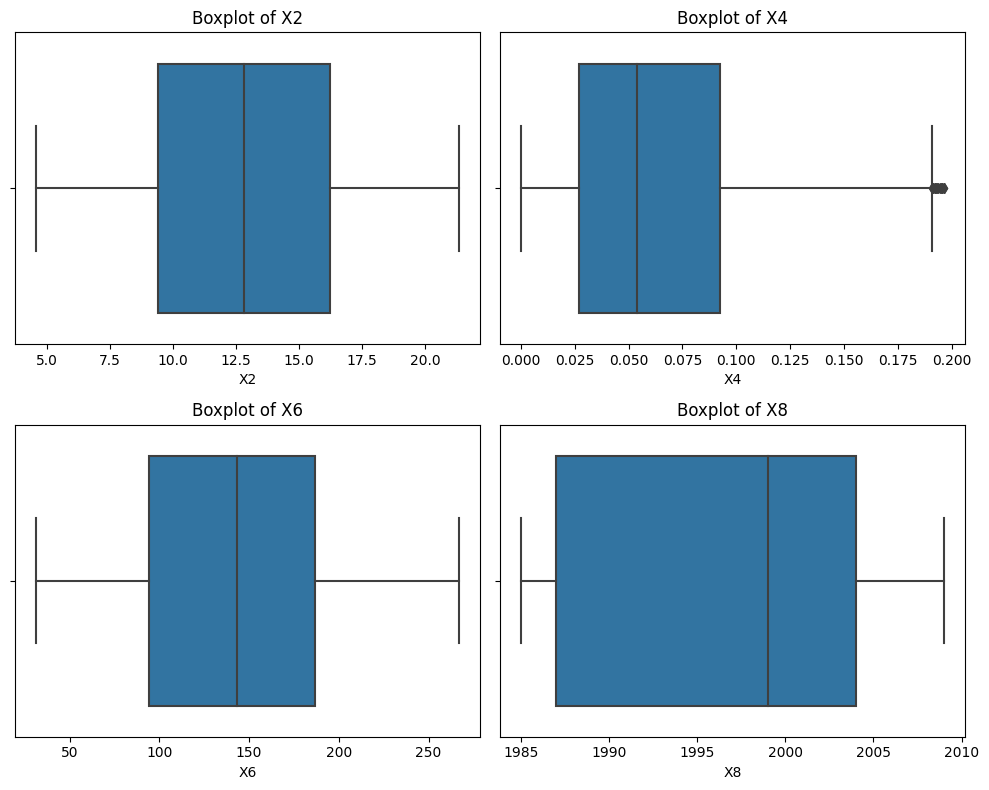

In [ ]:
# Now that data is clean, a boxplot helps visualize the outliers we're about to handle.
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, col in zip(axes.flatten(), numeric_cols):
    sns.boxplot(x=train_df[col], ax=ax, orient='h')
    ax.set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

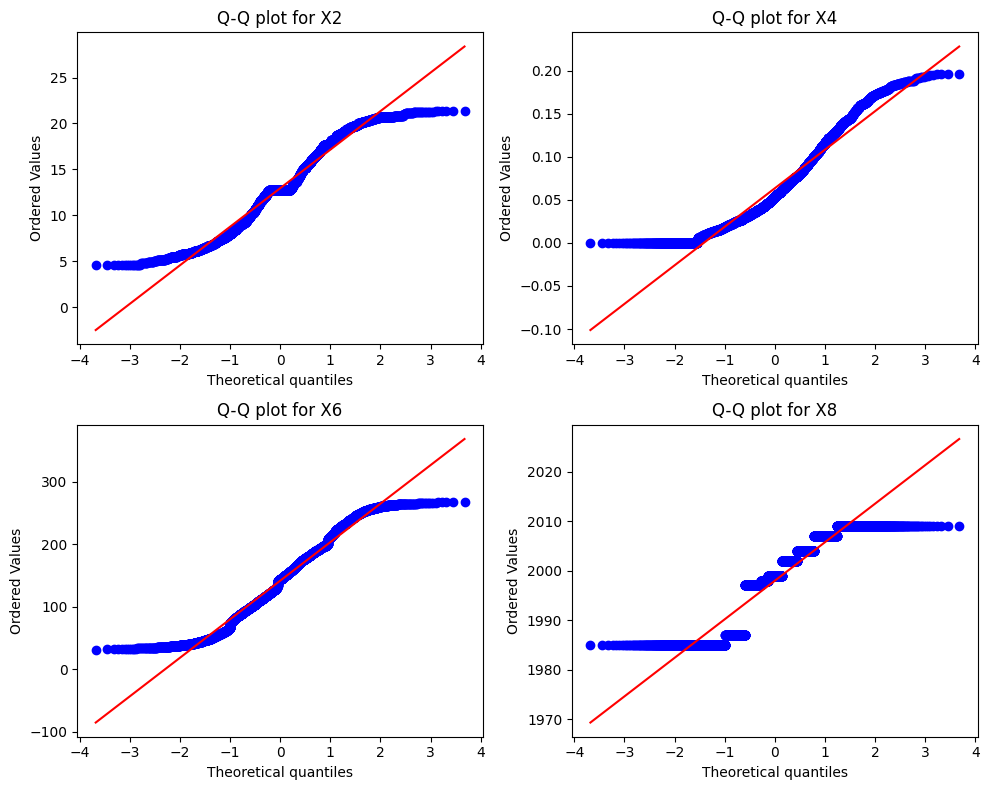

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, col in zip(axes.flatten(), numeric_cols):
  stats.probplot(train_df[col], plot=ax, dist="norm")
  ax.set_title(f'Q-Q plot for {col}') # Use set_title instead of title
plt.tight_layout()
plt.show()

In [ ]:
train_df.X3.unique(), train_df.X9.unique(), train_df.X10.unique(), train_df.X11.unique()

(array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object),
 array(['Medium', 'High', 'Small'], dtype=object),
 array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object),
 array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
        'Supermarket Type3'], dtype=object))

In [ ]:
# Clean up inconsistent values in X3
train_df['X3'] = train_df['X3'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})
test_df['X3'] = test_df['X3'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})

In [ ]:
train_df.X3.unique(), train_df.X9.unique(), train_df.X10.unique(), train_df.X11.unique()

(array(['Low Fat', 'Regular'], dtype=object),
 array(['Medium', 'High', 'Small'], dtype=object),
 array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object),
 array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
        'Supermarket Type3'], dtype=object))

In [ ]:
train_df.X5.unique(), train_df.X7.unique(), train_df.X11.unique()

(array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
        'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
        'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
        'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object),
 array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
        'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object),
 array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
        'Supermarket Type3'], dtype=object))

In [ ]:
x_train = train_df.drop('Y', axis=1)
y_train = train_df['Y']

x_test = test_df.copy()

# Preprocessing

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

ord_cols = ['X3', 'X9', 'X10']
nominal_cols = ['X0', 'X5', 'X7', 'X11']
# Define column lists early
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
if 'Y' in numeric_cols:
    numeric_cols.remove('Y') # Exclude target from operations


x3map = ['Low Fat', 'Regular']
x9map = ['Small', 'Medium', 'High']
x10map = ['Tier 1', 'Tier 2', 'Tier 3']

preprocessor = ColumnTransformer(
    transformers =[
        ('droper', 'drop', ['X1'] ),
        ('ordin', OrdinalEncoder(categories=[x3map, x9map, x10map]), ord_cols),
        ('1hot', OneHotEncoder(handle_unknown='ignore'), nominal_cols),
        ('scaler', RobustScaler(), numeric_cols) # Scale only numeric columns
        ],
        remainder='passthrough' # Apply 'passthrough' to all other columns not mentioned in the transformer
)

#### we didn't include X1 in the encoding. That was a deliberate choice.

X1 is a high-cardinality identifier. Here's what that means and why it's problematic:

High Cardinality: The column contains many unique values (FDA15, DRC01, FDN15, etc.). There are likely hundreds or even thousands of different item IDs.

No Generalizable Pattern: The model's goal is to learn patterns that apply to new, unseen data. A model that learns "item FDA15 sells well" has only memorized a fact; it hasn't learned why. It will have no idea how to predict sales for a new item, FDT58, that it has never seen before. Including the raw ID would cause the model to overfit by essentially memorizing the training data.

Curse of Dimensionality: If we were to One-Hot Encode this feature, we would create thousands of new columns, making our dataset massive and our model very slow and inefficient.

#### The Professional Approach (Feature Engineering):

Instead of using the ID directly, a more advanced technique is to engineer a new feature from it. The first two letters seem to be a category code:

FD -> Food

DR -> Drinks

NC -> Non-Consumable

We could create a new column called Item_Category and extract these prefixes. This new feature would have low cardinality (only 3 unique values) and would be genuinely useful for the model. For simplicity in the initial script, I just dropped it, which is also a very common and valid approach.

In [ ]:
X_train_processed = preprocessor.fit_transform(x_train).toarray()
X_test_processed = preprocessor.transform(x_test).toarray()

y_trainarr = y_train.values
# law e7tagt el dataframe versions menhom fe 7aga ya3ny
train_processeddf = pd.DataFrame(X_train_processed)
test_processeddf = pd.DataFrame(X_test_processed)

print("Data preprocessing complete.")

Data preprocessing complete.


# Random Forest Model

In [ ]:
rf = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=4)
rf.fit(X_train_processed, y_train)
rf.score(X_train_processed, y_train)

0.958313673157502

In [ ]:
# Feature Engineering - Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_processed)
X_test_poly = poly.transform(X_test_processed)

In [ ]:
#rf2 = RandomForestRegressor(n_estimators=5000, random_state=42, n_jobs=4)
#rf2.fit(X_train_poly, y_train)
#rf2.score(X_train_poly, y_train)

In [ ]:
#y_test = rf2.predict(X_test_poly)
y_test = rf.predict(X_test_processed)
submi = sample_submission.copy()

In [ ]:
submi['Y'] = y_test[:len(sample_submission)]

In [ ]:
submi.to_csv('submission.csv', index=False)

In [ ]:
#0.952

In [ ]:
#0.958313673157502